In [0]:
import numpy as np
import pandas as pd
import os
import sys
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

In [0]:
trainset.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [0]:
trainset.dtypes

id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

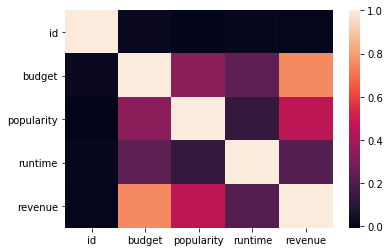

In [0]:
sns.heatmap(trainset.corr())

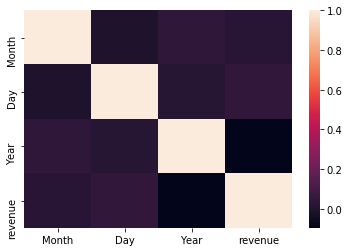

In [0]:
trainset[['Month','Day', 'Year']] = trainset['release_date'].str.split('/',expand=True)
trainset_release_date = trainset[['Month', 'Day', 'Year', 'revenue']]
trainset_release_date

trainset_release_date = trainset_release_date.astype(float)

trainset_release_date

cor = trainset_release_date.corr()

sns.heatmap(cor)

trainset = trainset.drop(['Year'], axis=1)

In [0]:
trainset.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
Month                       0
Day                         0
dtype: int64

In [0]:
runtime_mean = trainset['runtime'].mean()
print(runtime_mean)
trainset['runtime'] = trainset['runtime'].replace(0, runtime_mean)

107.85657104736491


In [0]:
trainset['homepage'] = trainset['homepage'].fillna(0)
trainset.loc[trainset['homepage'] != 0, 'homepage'] = 1

In [0]:
# Using function "from https://www.kaggle.com/tijlkindt/simple-tmdb-prediction-with-linear-regression - Simple TMDB prediction with Linear Regression" for JSON Treatment 

def proc_json(string, key):
    try:
        data = eval(string)
        return ",".join([d[key] for d in data])
    except:
        return ''

def proc_json_len(string):
    try:
        data = eval(string)
        return len(data)
    except:
        return 0


trainset.belongs_to_collection = trainset.belongs_to_collection.apply(lambda x: proc_json(x, 'name'))

trainset.genres = trainset.genres.apply(lambda x: proc_json(x, 'name'))

trainset.production_companies = trainset.production_companies.apply(lambda x: proc_json(x, 'name'))

trainset.production_countries = trainset.production_countries.apply(lambda x: proc_json(x, 'iso_3166_1'))

trainset.spoken_languages = trainset.spoken_languages.apply(lambda x: proc_json(x, 'iso_639_1'))

trainset.Keywords = trainset.Keywords.apply(lambda x: proc_json(x, 'name'))

trainset.cast = trainset.cast.apply(proc_json_len)

trainset.crew = trainset.crew.apply(proc_json_len)


In [0]:
#Genres Treatment

genres = []
for idx, val in trainset.genres.iteritems():
    gen_list = val.split(',')
    for gen in gen_list:
        if gen == '':
            continue

        if gen not in genres:
            genres.append(gen)
            

genre_column_names = []
for gen in genres:
    col_name = 'genres' + gen.replace(' ', '_')
    trainset[col_name] = trainset.genres.str.contains(gen).astype('uint8')
    genre_column_names.append(col_name)

trainset.drop(['genres'], axis=1)

,id,belongs_to_collection,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,genresMusic,genresCrime,genresScience_Fiction,genresMystery,genresForeign,genresFantasy,genresWar,genresWestern,genresHistory,genresTV_Movie
0,1,Hot Tub Time Machine Collection,14000000,0,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,0,0,0,0,0,0,0,0,0,0
1,2,The Princess Diaries Collection,40000000,0,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,0,0,0,0,0,0,0,0,0,0
2,3,,3300000,1,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,0,0,0,0,0,0,0,0,0,0
3,4,,1200000,1,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,0,0,0,0,0,0,0,0,0,0
4,5,,0,0,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,0,0,0,0,0,0,0,0,0,0
5,6,,8000000,0,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,...,0,0,0,0,0,0,0,0,0,0
6,7,,14000000,1,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,/4QjzFuaZmB4btGnLwAgdp23BzIU.jpg,...,0,0,0,0,0,0,0,0,0,0
7,8,,0,0,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,/83BV8fGy5p9i8RwE9oj76tZ1Ikp.jpg,...,0,0,0,0,0,0,0,0,0,0
8,9,The Muppet Collection,0,0,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,/5A8gKzOrF9Z7tSUX6xd5dEx4NXf.jpg,...,1,0,0,0,0,0,0,0,0,0
9,10,,6000000,0,tt0310281,en,A Mighty Wind,"In ""A Mighty Wind"", director Christopher Guest...",4.672036,/xwD4EsPOGLuKP50Q1gwqAsyhAFB.jpg,...,1,0,0,0,0,0,0,0,0,0


In [0]:
#Target Encoding from categorical variables


means = trainset.groupby('overview')['revenue'].mean()
trainset['overview'] = trainset['overview'].map(means)

means = trainset.groupby('Keywords')['revenue'].mean()
trainset['Keywords'] = trainset['Keywords'].map(means)

means = trainset.groupby('original_language')['revenue'].mean()
trainset['original_language'] = trainset['original_language'].map(means)

means = trainset.groupby('original_title')['revenue'].mean()
trainset['original_title'] = trainset['original_title'].map(means)

means = trainset.groupby('production_countries')['revenue'].mean()
trainset['production_countries'] = trainset['production_countries'].map(means)

means = trainset.groupby('production_companies')['revenue'].mean()
trainset['production_companies'] = trainset['production_companies'].map(means)

means = trainset.groupby('status')['revenue'].mean()
trainset['status'] = trainset['status'].map(means)

means = trainset.groupby('original_title')['revenue'].mean()
trainset['original_title'] = trainset['original_title'].map(means)

In [0]:
trainset = trainset.drop(['belongs_to_collection', 'genres', 'imdb_id', 'poster_path', 'release_date', 'spoken_languages', 'tagline', 'title'], axis=1)

In [0]:
trainset = trainset.astype(np.float64)

In [0]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split



trainset_features = trainset.drop(['revenue'], axis=1).values
trainset_target = trainset['revenue'].values


In [0]:
X_train, X_test, y_train, y_test = train_test_split(trainset_features, trainset_target,
                                                    train_size=0.75, test_size=0.25)


tpot = TPOTClassifier(generations=5, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_iris_pipeline.py')

Imputing missing values in feature set


C:\Users\Utilizador\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)




TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GaussianNB(input_matrix)
Imputing missing values in feature set
0.021333333333333333


In [0]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)


y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)


print('Feature importances:', list(gbm.feature_importances_))

estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

[1]	valid_0's l2: 1.91014e+16	valid_0's l1: 7.4815e+07
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1.73995e+16	valid_0's l1: 7.11082e+07
[3]	valid_0's l2: 1.58933e+16	valid_0's l1: 6.76541e+07
[4]	valid_0's l2: 1.45256e+16	valid_0's l1: 6.43683e+07
[5]	valid_0's l2: 1.32476e+16	valid_0's l1: 6.12217e+07
[6]	valid_0's l2: 1.21031e+16	valid_0's l1: 5.82111e+07
[7]	valid_0's l2: 1.10234e+16	valid_0's l1: 5.53504e+07
[8]	valid_0's l2: 1.00466e+16	valid_0's l1: 5.26344e+07
[9]	valid_0's l2: 9.16298e+15	valid_0's l1: 5.00524e+07
[10]	valid_0's l2: 8.36304e+15	valid_0's l1: 4.75972e+07
[11]	valid_0's l2: 7.6359e+15	valid_0's l1: 4.52593e+07
[12]	valid_0's l2: 7.01737e+15	valid_0's l1: 4.30774e+07
[13]	valid_0's l2: 6.41881e+15	valid_0's l1: 4.09651e+07
[14]	valid_0's l2: 5.87918e+15	valid_0's l1: 3.89636e+07
[15]	valid_0's l2: 5.38853e+15	valid_0's l1: 3.706e+07
[16]	valid_0's l2: 4.9444e+15	valid_0's l1: 3.52509e+07
[17]	valid_0's l2: 4.54165e+15	valid_0's 

In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)


Starting training...
[1]	valid_0's l2: 1.74275e+16	valid_0's l1: 7.10022e+07
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1.44964e+16	valid_0's l1: 6.40492e+07
[3]	valid_0's l2: 1.21653e+16	valid_0's l1: 5.79237e+07
[4]	valid_0's l2: 1.02274e+16	valid_0's l1: 5.22797e+07
[5]	valid_0's l2: 8.62373e+15	valid_0's l1: 4.72519e+07
[6]	valid_0's l2: 7.20733e+15	valid_0's l1: 4.25925e+07
[7]	valid_0's l2: 6.05313e+15	valid_0's l1: 3.84009e+07
[8]	valid_0's l2: 5.11432e+15	valid_0's l1: 3.4631e+07
[9]	valid_0's l2: 4.35642e+15	valid_0's l1: 3.12663e+07
[10]	valid_0's l2: 3.73053e+15	valid_0's l1: 2.82147e+07
[11]	valid_0's l2: 3.18505e+15	valid_0's l1: 2.54827e+07
[12]	valid_0's l2: 2.7431e+15	valid_0's l1: 2.30653e+07
[13]	valid_0's l2: 2.37662e+15	valid_0's l1: 2.0862e+07
[14]	valid_0's l2: 2.07441e+15	valid_0's l1: 1.88782e+07
[15]	valid_0's l2: 1.82542e+15	valid_0's l1: 1.70882e+07
[16]	valid_0's l2: 1.62476e+15	valid_0's l1: 1.54949e+07
[17]	valid_0's l2:

In [0]:
from lightgbm import LGBMRegressor

lr = LGBMRegressor(boosting_type='dart',num_leaves=20,max_depth=-1,min_data_in_leaf=20, learning_rate=0.2,n_estimators=500,subsample_for_bin=200000,
                   class_weight=None,min_split_gain=0.0,min_child_weight=0.001,subsample=0.1,subsample_freq=0,colsample_bytree=0.75,reg_alpha=0.0,reg_lambda=0.0,
                   random_state=101,n_jobs=-1)

lr.fit(X_train, y_train,eval_set=[(X_test, y_test)])
pred = lr.predict(X_test, num_iteration=lr.best_iteration_)

[1]	valid_0's l2: 1.41269e+16
[2]	valid_0's l2: 9.52787e+15
[3]	valid_0's l2: 6.52185e+15
[4]	valid_0's l2: 4.48487e+15
[5]	valid_0's l2: 3.16098e+15
[6]	valid_0's l2: 2.31465e+15
[7]	valid_0's l2: 1.77999e+15
[8]	valid_0's l2: 1.38073e+15
[9]	valid_0's l2: 1.11486e+15
[10]	valid_0's l2: 1.43477e+15
[11]	valid_0's l2: 1.15019e+15
[12]	valid_0's l2: 9.63934e+14
[13]	valid_0's l2: 8.33451e+14
[14]	valid_0's l2: 7.36371e+14
[15]	valid_0's l2: 8.3926e+14
[16]	valid_0's l2: 7.41904e+14
[17]	valid_0's l2: 8.30236e+14
[18]	valid_0's l2: 8.2458e+14
[19]	valid_0's l2: 7.2826e+14
[20]	valid_0's l2: 6.63256e+14
[21]	valid_0's l2: 6.16769e+14
[22]	valid_0's l2: 6.35619e+14
[23]	valid_0's l2: 6.63535e+14
[24]	valid_0's l2: 6.1315e+14
[25]	valid_0's l2: 5.74333e+14
[26]	valid_0's l2: 5.46063e+14
[27]	valid_0's l2: 6.45596e+14
[28]	valid_0's l2: 1.21137e+15
[29]	valid_0's l2: 9.89638e+14
[30]	valid_0's l2: 8.33503e+14
[31]	valid_0's l2: 8.35979e+14
[32]	valid_0's l2: 7.19318e+14
[33]	valid_0's l2: 6.